# 4. 自动求导

## 4.1 理解

- 逼近法就是积分（integral calculus）的起源。
- 在微分学最重要的应用是优化问题，即考虑如何把事情做到最好。
- 在深度学习中，我们“训练”模型，不断更新它们，使它们在看到越来越多的数据时变得越来越好。通常情况下，变得更好意味着最小化一个损失函数（loss function），即一个衡量“我们的模型有多糟糕”这个问题的分数。最终，我们真正关心的是生成一个能够在我们从未见过的数据上表现良好的模型。但我们只能将模型与我们实际能看到的数据相拟合。因此，我们可以将拟合模型的任务分解为两个关键问题：

（1）优化（optimization）：用模型拟合观测数据的过程；

（2）泛化（generalization）：数学原理和实践者的智慧，能够指导我们生成出有效性超出用于训练的数据集本身的模型。

## 4.2 梯度
梯度是一个向量，其分量是多变量函数相对于其所有变量的偏导数。

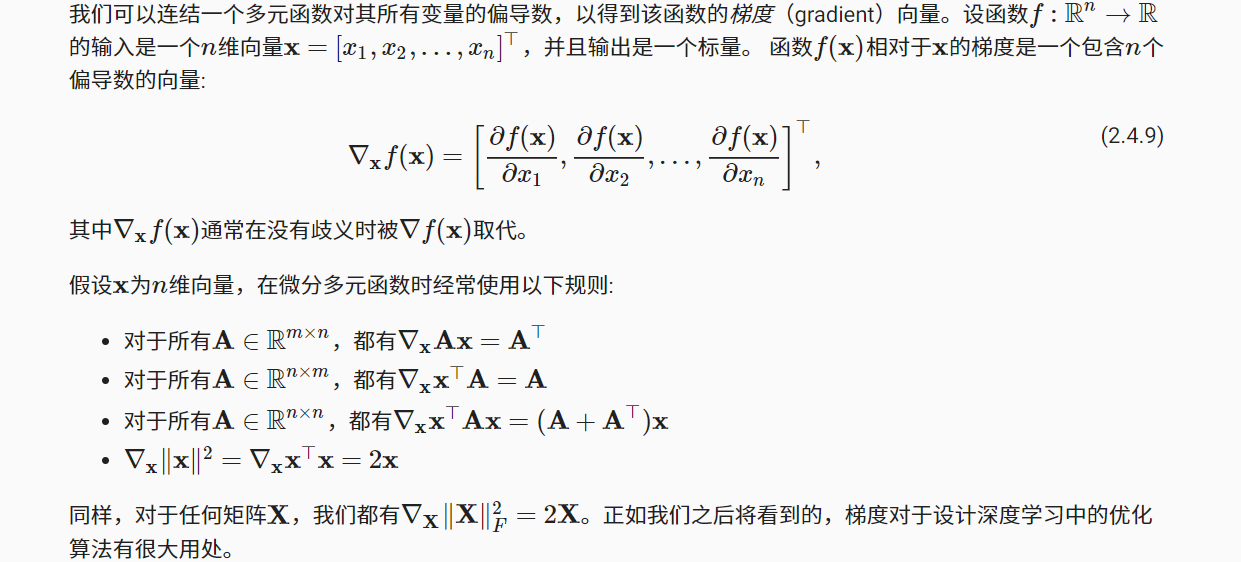


## 4.3 .requires_grad与.grad_fn
如果需要为张量计算梯度，则设置requires_grad=True。
创建一个Tensor并设置requires_grad=True（注意这里只能是Tensor而不是tensor，关于这两者的区别前面的文章已经提过了）：

In [2]:
import torch
x = torch.ones(2, 2, requires_grad=True)  #需要一个地方来存储梯度，等同于x = torch.ones(2, 2），x.reequires_grad_(True)
print(x)
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


上面的代码中：
- 将其属性.requires_grad设置为True，它将开始追踪(track)在其上的所有操作（这样就可以利用链式法则进行梯度传播了）。
- 每个Tensor都有一个.grad_fn属性，该属性即创建该Tensor的Function, 就是说该Tensor是不是通过某些运算得到的。若是，则grad_fn返回一个与这些运算相关的对象，否则是None。
- 上面的结果是None，说明x不是通过运算得到的，事实也的确如此，我们是直接得到全为1的矩阵，而没有通过运算。
- 像x这种直接创建的称为叶子节点，叶子节点对应的grad_fn是None。

In [3]:
y = x + 2
print(y)
print(y.grad_fn)
print(y.is_leaf)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
False


- 在这里，y是通过一个加法操作创建的，所以它有一个为<AddBackward0>的grad_fn。
- y就不是叶子节点。
    
再来点更复杂的运算：

In [4]:
z = y * y * 2
out = z.mean()  #求平均数
print(z)
print(out)

tensor([[18., 18.],
        [18., 18.]], grad_fn=<MulBackward0>)
tensor(18., grad_fn=<MeanBackward0>)


还可以通过.requires_grad_()来用in-place的方式改变requires_grad属性：

In [5]:
x = torch.randn(2, 2)  # 缺失情况下默认 requires_grad = False
print(x, x.grad_fn, x.requires_grad)
y = ((x * 3) / (x - 1))
print(y, y.grad_fn, y.requires_grad)

tensor([[ 1.8788, -0.7913],
        [ 0.7268, -0.1690]]) None False
tensor([[ 6.4139,  1.3252],
        [-7.9830,  0.4337]]) None False


上面的代码中，默认了requires_grad = False，所以出来的.grad_fn结果全是None，现在改变requires_grad属性：

In [6]:
x.requires_grad_(True)  #这一步也可以写成x.requires_grad = True，结果一样
print(x, x.grad_fn, x.requires_grad)
z = (x * x).sum()
print(z, z.grad_fn, z.requires_grad)

tensor([[ 1.8788, -0.7913],
        [ 0.7268, -0.1690]], requires_grad=True) None True
tensor(4.7128, grad_fn=<SumBackward0>) <SumBackward0 object at 0x00000235272AFA60> True


## 4.4 调用.backward()反向传播来完成所有梯度计算

这里的反向传播实际上就和我求导的顺序一致。

In [68]:
x = torch.arange(4.0)
x.requires_grad_(True)
x, x.grad, 3 * x * x

(tensor([0., 1., 2., 3.], requires_grad=True),
 None,
 tensor([ 0.,  3., 12., 27.], grad_fn=<MulBackward0>))

In [69]:
y = (3 * x * x).mean()
print(y)  

tensor(10.5000, grad_fn=<MeanBackward0>)


- 此时y是一个标量，所以调用backward()时不需要指定求导变量，否则需要传入一个与out同形的Tensor。等价于 out.backward(torch.tensor(1.))
- y=(3x^2)/4，y'=3/2 * x

In [70]:
y.backward()
print(x.grad)
print(x.grad == 3/2 * x)

tensor([0.0000, 1.5000, 3.0000, 4.5000])
tensor([True, True, True, True])


In [71]:
y = x.sum()
y.backward()
x, y, x.grad

(tensor([0., 1., 2., 3.], requires_grad=True),
 tensor(6., grad_fn=<SumBackward0>),
 tensor([1.0000, 2.5000, 4.0000, 5.5000]))

从上面的x.grad可以看出，在默认情况下，PyTorch会累积梯度，本来dy/dx=tensor([1., 1., 1., 1.])，但是由于累积了上面的dy/dx=tensor([0.0000, 1.5000, 3.0000, 4.5000])，使得我们现在得出的x.grad=tensor([1.0000, 2.5000, 4.0000, 5.5000]))，也就是两个x.grad累加了起来。

这是不好的，我们一般需要用x.grad.zero_()来清楚之前的值：

In [72]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])